# Importamos utilidades y definimos constantes

In [1]:
import glob
import sys
import os

import numpy as np
import math
from numpy import linspace
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
import pandas as pd

#%matplotlib notebook
%matplotlib inline
#%matplotlib qt

from IPython.display import display
import matplotlib.pyplot as plt
plt.style.use('classic')
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

import random

#constants and conversion factors 
pi         = math.pi
c          = 299792458.
hbar       = 6.62606896/(2*pi)*1e-34
e          = 1.6021773*1e-19
G          = 6.6738*1e-11
Mpc        = 3.085678*1e22   #equivalence m <-> Mpc
Modot      = 1.98855e+30     #solar mass in kg
kB         = 1.3806504*1e-23
Mpl        = math.sqrt(hbar*c/(8*pi*G))*c**2/e        #reduced Planck mass in eV
c8piGeVm2  = 16*pi**2*G*e**2/(2*pi*hbar*c**5)         #value of 8piG in eV^-2
eV2toMpcm2 = (2*pi*e*Mpc/(c*2*pi*hbar))**2            #conversion factor 1eV^2 = (eV2toMpcm2)*Mpc^-2

# Cargamos los valores de la simulación


In [5]:
Lbox    = 200            #size of the box
h       = 0.6768         #H0/100
Omm     = 0.305          #density parameter of matter

#path to gadget & rockstar files
snap_ini      =  'path/to/part_00001' 
#snap_today    = not necessary
parents_today = 'path/to/parents.dat'
halos_today   = 'path/to/halos_0'

#############################################

Mpart = 5.05026e+09        #mass resolution (M_\odot h^{-1}) in our simulations 
Mlow = 100*Mpart           #lower bound for M 
Mtop = 150000*Mpart        #upper bound for M
nbins = 9                  #number of bins in logM

Mth = 1.21e+11  #2             #mass threshold (M_\odot h^{-1}) to define IN (OUT) classes.  
                               ##This threshold was selectedin order to have 
                               ## approximately 30% of the total particles in the IN class.
                               ## Feel free to change the value

grid    = 512              #size of the grid
wfilter = 'Top-Hat'        #smoothing function
#################################################


#background density of matter
Gc      = G*Modot/(c**2*Mpc)
H02     = 1.e10*h**2/(c**2)
rho_bar = 3./(8*pi*Gc)*Omm*H02
print 'rho_m background [Modot/Mpc**3]: ',rho_bar

rho_m background [Modot/Mpc**3]:  38774199065.2


# Funciones de utilidad

In [6]:
def particle_selection(snapshot,nsamples=10):
    '''
    This function returns a data frame (df) with columns 
               X   Y   Z   particle_ID 
    Input:
        snapshot: the path of gadget files at some z
        nsamples: the number of particles to be selected
    Returns:
        df containing selected particles   
    '''
    
    #data frame assembly 
    pid = readsnap(snapshot,'pid','dm')    #this is a numpy array
    pos = readsnap(snapshot,'pos','dm')
    selection = pd.DataFrame(data=pos,columns=['X','Y','Z'])
    selection['particle_ID'] = pid

    #here we select the particles to be studied (more efficient than isin)
    selection = selection.sample(n=nsamples) 
    
    return selection

In [7]:
def particle_labels(selected_particles,halo_parents,halo_bin):
    '''
    This function uses pygadgetreader to return a label, which tells if a selected particle belongs to some 
    halo whose mass is above Mth   
    Input:
        selected_particles: df of selected particles consisting of position (X,Y,Z) and PID
        halo_parents      : path of the 'parents.dat' file produced by rockstar
        halo_bin          : path of the bin files produced by rockstar
    Returns:
        selected_flags    : array of flags, which tells if a selected particle belongs to some halo (True) or if
                            the particle is free (False)
        selected_hosts    : array of the IDs of the host halos containing the selected particles 
                            (-1 for free particles)
        selected_mass     : array with the mass of the host halos containing the selected particles
                            (-1 for free particles)
        selected_input    : array of integers, which tell if a selected particle belongs to some halo whose mass is
                            above Mth (1) or if the mass of the host halo is smaller than Mth (0) or if the 
                            particle is free (0)
        Warning: selected_flags is not the same as selected_input!
    '''
    #here we retrieve the IDs of the parent halos from 'parents.dat'
    
    
    #######Warning####
    ## Rockstar3 returns additional columns on its files, so be sure to check out
    ### the input in the 'columns' definition
    
    
    #columns = ['ID','DescID','M200c','Vmax','Vrms','R200c','Rs','Np','X','Y','Z','VX','VY','VZ','JX','JY','JZ',
               #'Spin','rs_klypin','M200c_all','M200b','M200c','M500c','M2500c','Xoff','Voff','spin_bullock',
               #'b_to_a','c_to_a','A[x]','A[y]','A[z]','b_to_a(500c)','PID']
    columns = ['ID','DescID','M200c','Vmax','Vrms','R200c','Rs','Np','X','Y','Z,','VX','VY','VZ','JX','JY','JZ',
               'Spin','rs_klypin','M200c_all','M200b','M200c','M500c','M2500c','Xoff','Voff','spin_bullock',
               'b_to_a', 'c_to_a','A[x]','A[y]','A[z]','b_to_a(500c)','c_to_a(500c)', 'A[x](500c)','A[y](500c)',
               'A[z](500c)','T/|U|','M_pe_Behroozi', 'M_pe_Diemer','Halfmass_Radius','PID']
    hosts = pd.read_csv(halo_parents,sep="\s+",skiprows=16,header=None)
    hosts.columns = columns
    hosts = hosts[hosts['PID']==-1]              #we filter out subhalos
    hosts_list = hosts['ID'].values.tolist()     #we export this array to a list

    #particles_hosts is a df consisting of two columns: particle_ID  & halo_ID (see pygadgetreader documentation),
    #where 'particle_ID' lists the IDs of the particles and 'halo_ID' lists the IDs of the host halos.
    #After constructing the df, we filter out subhalos
    temp = readrockstar(halo_bin,'particles')
    particles_hosts = pd.DataFrame(data=temp,columns=['particle_ID','halo_ID'])
    #here we remove subhalos from 'particles_hosts'
    particles_hosts = particles_hosts[particles_hosts['halo_ID'].isin(hosts_list)]

    #loop over selected particles
    selected_flags = []
    selected_hosts = np.zeros(len(selected_particles))
    selected_mass  = np.zeros(len(selected_particles))
    
    pid = selected_particles['particle_ID'].values
    
    for idx in range(0,len(pid)):
        if idx%1000 == 0:
            print( 'processing {} samples'.format(idx))
                
        #we determine whether a particle is free or belongs to some halo
        flag = pid[idx] in particles_hosts['particle_ID'].values
        selected_flags.append(flag)
        
        if flag == False:
            selected_hosts[idx] = -1
            selected_mass[idx]  = -1
        else:
            #if selected particle belongs to some halo, we find the ID of the host
            temp_df = particles_hosts[particles_hosts['particle_ID'] == pid[idx]]
            #we use [0] to extract the single element of this array
            temp_id = temp_df['halo_ID'].values[0]
            selected_hosts[idx] = temp_id
            
            #we compute the mass of the host by counting the number of particles it contains
            temp_df = particles_hosts[particles_hosts['halo_ID'] == temp_id]
            selected_mass[idx] = len(temp_df)*Mpart               
    
    #labels (1/0) indicating if a selected particle belongs to some halo whose mass is above Mth or not
    selected_labels = (selected_mass >= Mth)*1
    
    return selected_flags, selected_hosts, selected_mass, selected_labels

In [8]:
def deltaR_grid(snapshot,R,ngrid,wfunc):       
    '''
    This function uses pylians to compute the smooth density field for each cell in a rectangular grid
    Input:
        snpapshot: the path of gadget files at some z
        R        : the smoothing scale [in h^{-1} Mpc]
        ngrid    : the grid size 
        wfunc    : the filter function
    Returns:
        delta_grid : overdensity field in each cell: delta_m = (rho-\bar{\rho})/\bar{rho}
        deltaR_grid: smoothed density field on some scale R    
    '''
    
    #we first compute the density field rho (see pylians documentation)
    ptypes = [1]     #is CDM particles
    MAS    = 'CIC'   #cloud in cell
    do_RSD = False
    axis   = 0
    rho    = MASL.density_field_gadget(snapshot,ptypes,ngrid,MAS,do_RSD,axis)
    #then we compute \delta_m
    delta_grid = rho/np.mean(rho,dtype=np.float64)
    delta_grid -= 1.0
    
    #smoothing
    threads = 4
    W_k = SL.FT_filter(Lbox,R,ngrid,wfunc,threads)  #Fourier transform of the filter function
    deltaR_grid = SL.field_smoothing(delta_grid,W_k,threads)    
    
    return delta_grid, deltaR_grid

In [9]:
def input_vectors(snapshot,selected_particles):
    '''
    This function returns the input vectors to be analized by the AI algorithm
    Input:
        snapshot          : the path of gadget files at some z
        selected_particles: df of selected particles with columns: X  Y  Z  particle_ID
    Returns:
        input_vectors     : numpy array of shape (num_features,num_samples), where 'num_features'
                            refers to the different smoothing scales determined by Mlow, Mtop and
                            nbins. 'num_samples' refers to the number of selected particles to track                            
    '''
    #num_features: uniform spacing in logM
    logMlow = math.log10(Mlow)
    logMtop = math.log10(Mtop)
    logM    = np.linspace(logMlow,logMtop,num=nbins+1,endpoint=True)    
    num_features = len(logM)
    
    num_samples  = len(selected_particles)
    
    input_vectors = np.zeros((num_features,num_samples))
    
    #size of cells in h^{-1} kpc
    dl = Lbox*1000./grid
    
    #loop over features (that is, over the smoothed density field on different mass scales)
    for i in range(0,num_features):
        M    = 10**logM[i]    #mass scale in h^{-1}M_\odot
        Mabs = M/h            #mass scale in M_\odot
        Rabs = (Mabs/((4.*pi/3)*rho_bar))**(1./3) #conversion to radius scale. Rabs is in Mpc
        R    = Rabs*h         #radius scale in h^{-1}Mpc        
        delta_temp,deltaR_temp = deltaR_grid(snapshot,R,grid,wfilter)
        print ('mass scale [h^-1 M_\odot]: {:.5E}, length scale [h^-1 Mpc]: {:.5E}'.format(M,R))
        
        #once we get delta_R in the whole grid, we get delta_R in cells containing the selected particles
        #we use dl to locate the three indexes of these cells in the grid
        for j in range(0,num_samples):
            idx = int(selected_particles.iloc[j]['X']/dl)
            idy = int(selected_particles.iloc[j]['Y']/dl)
            idz = int(selected_particles.iloc[j]['Z']/dl)
            
            #finally, we fill in the info
            input_vectors[i][j] = deltaR_temp[idx][idy][idz]
    
    return input_vectors


# Aquí viene lo interesante y tricky

Es de gran vitalidad haber instalado pygadgetreader y pylians antes de correr todo el notebook, al momento de hacerlo es conveniente localizar su dirección, ya que hay una misma función definida en ambos programas es necesario removerlo, en este ejemplo yo tengo pygadgetreader y Pylians en la misma dirección

In [11]:
import sys
sys.path

['',
 '/home/jazhiel/Escritorio/Maestria/Machine_Learning/Cosmology_ML/pygadgetreader',
 '/home/jazhiel/Escritorio/Maestria/Machine_Learning/Cosmology_ML',
 '/home/jazhiel/anaconda2/lib/python27.zip',
 '/home/jazhiel/anaconda2/lib/python2.7',
 '/home/jazhiel/anaconda2/lib/python2.7/plat-linux2',
 '/home/jazhiel/anaconda2/lib/python2.7/lib-tk',
 '/home/jazhiel/anaconda2/lib/python2.7/lib-old',
 '/home/jazhiel/anaconda2/lib/python2.7/lib-dynload',
 '/home/jazhiel/.local/lib/python2.7/site-packages',
 '/home/jazhiel/anaconda2/lib/python2.7/site-packages',
 '/home/jazhiel/anaconda2/lib/python2.7/site-packages/Pylians-0.0.0-py2.7-linux-x86_64.egg',
 '/home/jazhiel/anaconda2/lib/python2.7/site-packages',
 '/home/jazhiel/.local/lib/python2.7/site-packages/IPython/extensions',
 '/home/jazhiel/.ipython']

primero remuevo pygadgetreader y otras direcciones que puedan tener conflicto con otras, por ejemplo las librerias de Pylians, es posible que cada computadora tenga diferentes direcciones, te darás cuenta al ejecutar

In [12]:
sys.path.remove('/home/jazhiel/Escritorio/Maestria/Machine_Learning/Cosmology_ML')
sys.path.remove('/home/jazhiel/Escritorio/Maestria/Machine_Learning/Cosmology_ML/pygadgetreader')
sys.path.remove('/home/jazhiel/.local/lib/python2.7/site-packages')
#sys.path.remove('/home/jazhiel/Escritorio/Maestria/Machine_Learning/Cosmology_ML/Pylians/library/build/lib.linux-x86_64-2.7')
sys.path.remove('/home/jazhiel/anaconda2/lib/python2.7/site-packages/Pylians-0.0.0-py2.7-linux-x86_64.egg')

sys.path

['',
 '/home/jazhiel/anaconda2/lib/python27.zip',
 '/home/jazhiel/anaconda2/lib/python2.7',
 '/home/jazhiel/anaconda2/lib/python2.7/plat-linux2',
 '/home/jazhiel/anaconda2/lib/python2.7/lib-tk',
 '/home/jazhiel/anaconda2/lib/python2.7/lib-old',
 '/home/jazhiel/anaconda2/lib/python2.7/lib-dynload',
 '/home/jazhiel/anaconda2/lib/python2.7/site-packages',
 '/home/jazhiel/anaconda2/lib/python2.7/site-packages',
 '/home/jazhiel/.local/lib/python2.7/site-packages/IPython/extensions',
 '/home/jazhiel/.ipython']

Aqui volví a cargar pygadgetreader dado que es la primera función que se utiliza para rastrear las partiulas de materia oscura en los datos

In [13]:
#se carga pygadgetreader
#import sys
sys.path.append('/home/jazhiel/Escritorio/Maestria/Machine_Learning/Cosmology_ML/pygadgetreader')
#sys.path.remove('/home/jazhiel/anaconda2/lib/python2.7/site-packages/pyGadgetReader-2.6-py2.7.egg')  #('/home/ealmaraz/software/pygadgetreader')    
sys.path.append('/usr/local/lib/python2.7/dist-packages/pyGadgetReader-2.6-py2.7.egg')
from pygadgetreader import *

#selected_particles



el siguiente comando inicia a rastrear los samples de la snap inicial y regresa un arreglo con su particle ID, es decir su posicion (ver función particle_selection).

Para esta cantidad de partículas el notebook tarda bastante, en mi máquina tarda de dos a tres horas, asi que paciencia

In [16]:
selected_particles = particle_selection(snap_ini,50000)

selected_particles

es en este punto donde se definen los hosts, mass, flags y labels


In [17]:
test_flags, test_hosts, test_mass, test_labels = particle_labels(selected_particles,parents_today,halos_today)

en dado caso que hayas tenido problemas no hay worries, Erick tuvo la amabilidad de crear un diccionario con las particulas

In [19]:
dict_data = np.load('nbody_data.npz')
test_flags  = dict_data['test_flags']
test_hosts  = dict_data['test_hosts']
test_mass   = dict_data['test_mass']
test_labels = dict_data['test_labels']
test_input  = dict_data['test_input']
#test_snid   = dict_data['test_snid']
#test_labels = dict_data['test_labels']
print(test_mass)
print(len(test_labels))


[-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 ...  3.43922706e+12
  3.73214214e+12 -1.00000000e+00]
50000


Ahora removemos pygadgetreader, todo lo que tenga que ver con sus librerias y el modulo 'pygadgetreader' y 'readgadget', que tambien usa pylians

In [20]:
sys.path.remove('/home/jazhiel/Escritorio/Maestria/Machine_Learning/Cosmology_ML/pygadgetreader')
sys.path.remove('/usr/local/lib/python2.7/dist-packages/pyGadgetReader-2.6-py2.7.egg')
del sys.modules['pygadgetreader']
del sys.modules['readgadget']  
sys.path

['',
 '/home/jazhiel/anaconda2/lib/python27.zip',
 '/home/jazhiel/anaconda2/lib/python2.7',
 '/home/jazhiel/anaconda2/lib/python2.7/plat-linux2',
 '/home/jazhiel/anaconda2/lib/python2.7/lib-tk',
 '/home/jazhiel/anaconda2/lib/python2.7/lib-old',
 '/home/jazhiel/anaconda2/lib/python2.7/lib-dynload',
 '/home/jazhiel/anaconda2/lib/python2.7/site-packages',
 '/home/jazhiel/anaconda2/lib/python2.7/site-packages',
 '/home/jazhiel/.local/lib/python2.7/site-packages/IPython/extensions',
 '/home/jazhiel/.ipython']

Cargamos ahora pylians


In [21]:
sys.path.append('/home/jazhiel/Escritorio/Maestria/Machine_Learning/Cosmology_ML/Pylians/library/build/lib.linux-x86_64-2.7')
import sys 
sys.path.append('/home/jazhiel/anaconda2/lib/python2.7/site-packages/Pylians-0.0.0-py2.7-linux-x86_64.egg')
import smoothing_library as SL
import MAS_library as MASL

como se menciona antes, input_vectors utiliza pylians para localizar las particulas, sus vectores que seran el input para las pruebas de machine learning

In [22]:
test_input = input_vectors(snap_ini,selected_particles)
print test_input

# Cross check $\delta r $ vs $M_{\odot}$

Esta parte utiliza los test_input para graficarlos en función de la escala a la que se encontraban y su trayectoria, el eje X es la masa en masas solares y el eje y la escala a la que se encontraban

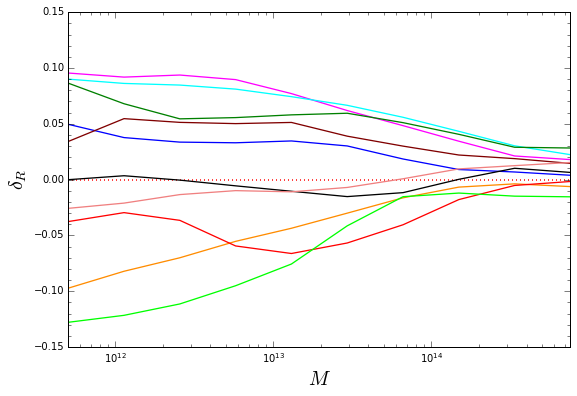

In [23]:

fig = plt.figure(figsize=(9,6))
ax = plt.subplot(111)


logMlow = math.log10(Mlow)
logMtop = math.log10(Mtop)
logM    = np.linspace(logMlow,logMtop,num=nbins+1,endpoint=True) 

samples = random.sample(range(0,100),10)
colors  = ['blue','magenta','black','maroon','lightcoral','darkorange','cyan','green','red','lime']

for idx in range(0,10):
    plt.plot(10**logM,test_input[:,samples[idx]],'-',color=colors[idx],linewidth=1.3)

plt.hlines(0,Mlow,Mtop,colors='red',linestyles='dotted',linewidth=1.5)

plt.xlabel('$M$',fontsize=20)
plt.xscale('log')
plt.xlim([Mlow,Mtop])
plt.ylabel('$\delta_R$',fontsize=20)
plt.ylim([-0.15,0.15])
minorLocatorY = AutoMinorLocator()
ax.yaxis.set_minor_locator(minorLocatorY)
plt.tick_params(which='major', length=6)
plt.tick_params(which='minor', length=3, color='black')

# Prueba para un perceptron (red neuronal)

Se define la función de matriz de confusión

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Para esta red estoy haciendo una prueba recursiva de 10 eventos (iterations = 10) se tienen 121 parametros, (10 * 10) de las layers, 10 de la funcion de activacion y los 10 parametros de entrada y uno de salida

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras import metrics

training_accuracy = []; training_loss = []
test_accuracy     = []; test_loss     = []
test_fpr          = []; test_tpr      = []; test_auc_roc = []
test_precision    = []; test_recall   = []; test_auc_pr  = []
test_confusion_matrix = []

#para scikit-learn: (samples,features)
test_input_T = test_input.T
X_train, X_test, y_train, y_test = train_test_split(test_input_T,test_labels,test_size=0.25,random_state=None)
print(len(y_test))

iterations = 10
for i in range(iterations):
    #ANN
    test1_model = models.Sequential()
    test1_model.add(layers.Dense(10,activation='relu',input_shape=(10,)))
#test1_model.add(layers.Dense(32,activation='relu'))
#test1_model.add(layers.Dense(32,activation='relu'))
#test1_model.add(layers.Dense(10,activation='relu'))
    test1_model.add(layers.Dense(1, activation='sigmoid'))

    test1_model.compile(optimizer=optimizers.RMSprop(lr=0.001),
                    loss=losses.binary_crossentropy,
                    metrics=['accuracy'])

    test1_model.summary()

    test1_model_history = test1_model.fit(X_train,
                                          y_train,
                                          epochs=20,
                                          batch_size=64,
                                          validation_data=(X_test,y_test),
                                          verbose=1)

#plot
    #fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,4.5))    

    results_dict = test1_model_history.history
    epochs = range(1,len(results_dict['accuracy'])+1)

#accuracy
    acc_values = results_dict['accuracy']
    val_acc_values = results_dict['val_accuracy']
    training_accuracy.append(results_dict['accuracy'])
    test_accuracy.append(results_dict['val_accuracy'])
    
    #axs[0].plot(epochs,training_accuracy[i],color='black',label='train',linewidth=1.5,linestyle='-')
    #axs[0].plot(epochs,test_accuracy[i],color='red',label='test',linewidth=1.5,linestyle='-')
    #axs[0].set_xlabel('epochs')
    #minorLocatorX = AutoMinorLocator()
    #axs[0].xaxis.set_minor_locator(minorLocatorX)
    #axs[0].set_ylabel('accuracy')
    #axs[0].set_ylim([0.5,1.02])   
    #minorLocatorY = AutoMinorLocator()
    #axs[0].yaxis.set_minor_locator(minorLocatorY)
    #axs[0].tick_params(which='major', length=6)
    #axs[0].tick_params(which='minor', length=3, color='black')       
    #axs[0].legend(loc='lower right')
    
#loss
    loss_values = results_dict['loss']
    val_loss_values = results_dict['val_loss']
    training_loss.append(results_dict['loss'])
    test_loss.append(results_dict['val_loss'])
       
    #axs[1].plot(epochs,training_loss[i],color='black',label='train',linewidth=1.5,linestyle='-')
    #axs[1].plot(epochs,test_loss[i],color='red',label='test',linewidth=1.5,linestyle='-')
    #axs[1].set_xlabel('epochs')
    #minorLocatorX = AutoMinorLocator()
    #axs[1].xaxis.set_minor_locator(minorLocatorX)   
    #axs[1].set_ylabel('loss')
    #minorLocatorY = AutoMinorLocator()
    #axs[1].yaxis.set_minor_locator(minorLocatorY)
    #axs[1].tick_params(which='major', length=6)
    #axs[1].tick_params(which='minor', length=3, color='black')    
    #axs[1].legend(loc='upper right')

    #axs[0].set_title('Training and test accuracy after {} epochs: \n {:.3f} (train), {:.3f} (validation)'
                     #.format(len(epochs),acc_values[-1],val_acc_values[-1]));

    #axs[1].set_title('Training and test loss after {} epochs: \n {:.3f} (train), {:.3f} (validation)'
                     #.format(len(epochs),loss_values[-1],val_loss_values[-1]));
    
    pred_class = test1_model.predict_classes(X_test)
    probs = test1_model.predict_proba(X_test)
    preds = probs[:,0]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    cm = confusion_matrix(y_test,pred_class)
    test_confusion_matrix.append(cm)


Using TensorFlow backend.


12500
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Train on 37500 samples, validate on 12500 samples
Epoch 1/20
37500/37500 [==============================] - 3s 93us/step - loss: 0.6014 - accuracy: 0.7424 - val_loss: 0.5239 - val_accuracy: 0.7662
Epoch 2/20
37500/37500 [==============================] - 2s 58us/step - loss: 0.4871 - accuracy: 0.7750 - val_loss: 0.4776 - val_accuracy: 0.7676
Epoch 3/20
37500/37500 [==============================] - 2s 60us/step - loss: 0.4680 - accuracy: 0.7776 - val_loss: 0.4731 - val_accuracy: 0.7678
Epoch 4/20
37500/3750

Epoch 3/20
37500/37500 [==============================] - 2s 54us/step - loss: 0.4599 - accuracy: 0.7789 - val_loss: 0.4643 - val_accuracy: 0.7754
Epoch 4/20
37500/37500 [==============================] - 2s 53us/step - loss: 0.4576 - accuracy: 0.7799 - val_loss: 0.4625 - val_accuracy: 0.7741
Epoch 5/20
37500/37500 [==============================] - 2s 54us/step - loss: 0.4563 - accuracy: 0.7793 - val_loss: 0.4618 - val_accuracy: 0.7752
Epoch 6/20
37500/37500 [==============================] - 2s 53us/step - loss: 0.4557 - accuracy: 0.7795 - val_loss: 0.4613 - val_accuracy: 0.7758
Epoch 7/20
37500/37500 [==============================] - 2s 53us/step - loss: 0.4553 - accuracy: 0.7801 - val_loss: 0.4610 - val_accuracy: 0.7753
Epoch 8/20
37500/37500 [==============================] - 2s 55us/step - loss: 0.4550 - accuracy: 0.7793 - val_loss: 0.4605 - val_accuracy: 0.7759
Epoch 9/20
37500/37500 [==============================] - 2s 54us/step - loss: 0.4547 - accuracy: 0.7798 - val_loss: 0

37500/37500 [==============================] - 2s 54us/step - loss: 0.4545 - accuracy: 0.7797 - val_loss: 0.4605 - val_accuracy: 0.7751
Epoch 10/20
37500/37500 [==============================] - 2s 54us/step - loss: 0.4543 - accuracy: 0.7805 - val_loss: 0.4601 - val_accuracy: 0.7762
Epoch 11/20
37500/37500 [==============================] - 2s 54us/step - loss: 0.4541 - accuracy: 0.7799 - val_loss: 0.4599 - val_accuracy: 0.7762
Epoch 12/20
37500/37500 [==============================] - 2s 53us/step - loss: 0.4539 - accuracy: 0.7803 - val_loss: 0.4604 - val_accuracy: 0.7747
Epoch 13/20
37500/37500 [==============================] - 2s 56us/step - loss: 0.4539 - accuracy: 0.7804 - val_loss: 0.4597 - val_accuracy: 0.7759
Epoch 14/20
37500/37500 [==============================] - 2s 55us/step - loss: 0.4537 - accuracy: 0.7807 - val_loss: 0.4596 - val_accuracy: 0.7764
Epoch 15/20
37500/37500 [==============================] - 2s 56us/step - loss: 0.4536 - accuracy: 0.7806 - val_loss: 0.4595

37500/37500 [==============================] - 2s 54us/step - loss: 0.4543 - accuracy: 0.7798 - val_loss: 0.4601 - val_accuracy: 0.7749
Epoch 16/20
37500/37500 [==============================] - 2s 54us/step - loss: 0.4541 - accuracy: 0.7807 - val_loss: 0.4601 - val_accuracy: 0.7754
Epoch 17/20
37500/37500 [==============================] - 2s 57us/step - loss: 0.4541 - accuracy: 0.7814 - val_loss: 0.4598 - val_accuracy: 0.7760
Epoch 18/20
37500/37500 [==============================] - 2s 55us/step - loss: 0.4540 - accuracy: 0.7810 - val_loss: 0.4597 - val_accuracy: 0.7754
Epoch 19/20
37500/37500 [==============================] - 2s 55us/step - loss: 0.4539 - accuracy: 0.7811 - val_loss: 0.4597 - val_accuracy: 0.7752
Epoch 20/20
37500/37500 [==============================] - 2s 56us/step - loss: 0.4538 - accuracy: 0.7809 - val_loss: 0.4596 - val_accuracy: 0.7756
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output 

Train on 37500 samples, validate on 12500 samples
Epoch 1/20
37500/37500 [==============================] - 2s 59us/step - loss: 0.5522 - accuracy: 0.7594 - val_loss: 0.4817 - val_accuracy: 0.7682
Epoch 2/20
37500/37500 [==============================] - 2s 55us/step - loss: 0.4670 - accuracy: 0.7772 - val_loss: 0.4683 - val_accuracy: 0.7694
Epoch 3/20
37500/37500 [==============================] - 2s 53us/step - loss: 0.4602 - accuracy: 0.7788 - val_loss: 0.4641 - val_accuracy: 0.7743
Epoch 4/20
37500/37500 [==============================] - 2s 60us/step - loss: 0.4574 - accuracy: 0.7800 - val_loss: 0.4623 - val_accuracy: 0.7742
Epoch 5/20
37500/37500 [==============================] - 2s 55us/step - loss: 0.4560 - accuracy: 0.7802 - val_loss: 0.4617 - val_accuracy: 0.7750
Epoch 6/20
37500/37500 [==============================] - 2s 63us/step - loss: 0.4554 - accuracy: 0.7799 - val_loss: 0.4611 - val_accuracy: 0.7749
Epoch 7/20
37500/37500 [==============================] - 2s 57us/st

Ploteamos la curva ROC


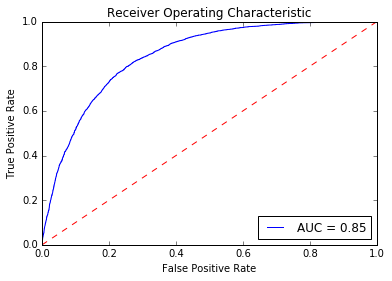

In [26]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#plt.scatter(fpr,tpr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

LA desviacion standar y promedio de la matriz de confusion

In [27]:
test_confusion_matrix_mean = sum(test_confusion_matrix)/len(test_confusion_matrix)
variance=sum([((x - test_confusion_matrix_mean) ** 2) for x in test_confusion_matrix])/len(test_confusion_matrix) 
test_confusion_matrix_std = variance ** 0.5
print('confusion matrix mean:')
print(test_confusion_matrix_mean)
print('confusion matrix std:')
print(test_confusion_matrix_std)

confusion matrix mean:
[[6710 1375]
 [1428 2985]]
confusion matrix std:
[[53.37 53.36]
 [46.53 46.53]]


y ploteamos la matriz de confusion

Confusion matrix, without normalization
[[6626 1460]
 [1345 3069]]


<Figure size 432x288 with 0 Axes>

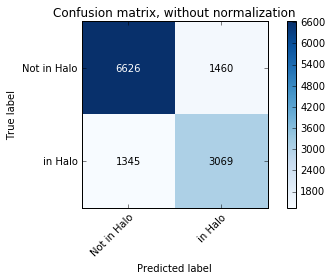

In [29]:
class_names=['Not in Halo','in Halo']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(y_test, pred_class, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.82 0.18]
 [0.3  0.7 ]]


<Figure size 432x288 with 0 Axes>

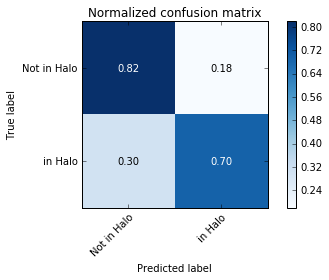

In [31]:
class_names=['Not in Halo','in Halo']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(y_test, pred_class, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')